In [1]:
%load_ext autoreload
%autoreload 2
import HyperParam as hp
import AEhelper as ae
import tensorflow as tf
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import tqdm

from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import optimizers
from pandas import DataFrame

pd.set_option("display.max_columns",200)

In [2]:
def zizagcode(arrary,imgsize=16):
    #锯齿形编码填充
    zigzag=np.zeros([imgsize,imgsize])
    row=zigzag.shape[0]
    colum=zigzag.shape[1]
    i,j,k=0,0,0
    while i < row and j < colum and k < len(arrary):
        zigzag[i,j]=arrary[k]
        k+=1
        #i+j为偶数，向右上方向移动
        if (i+j)%2==0 :
            #如果右边界超出，则向下
            if (i-1) in range(row) and (j+1) not in range(colum):
                i+=1
            #如果上边界超出，则向下
            elif (i-1) not in range(row) and (j+1) in range(colum):
                j+=1
            #如果右上边界都超出，则向下
            elif (i-1) not in range(row) and (j+1) not in range(colum):
                i+=1
            else:
                i-=1
                j+=1
        #i+j为奇数，则向左下移动
        elif (i+j)%2==1:
            #如果左边界超出，则向下
            if (i+1) in range(row) and (j-1) not in range(colum):
                i+=1
            #如果上边界超出，则向下
            elif (i+1) not in range(row) and (j-1) in range(colum):
                j+=1
            #如果右上边界都超出，则向下
            elif (i+1) not in range(row) and (j-1) not in range(colum):
                j+=1
            else:
                i+=1
                j-=1
    
    #zigza填充结束，进行IDCT
    idct=cv2.idct(zigzag.flatten())
    img=idct.reshape([imgsize,imgsize,1])
    
    return img

In [3]:
def label_change(x):
    if(x == 'Benign'):
        return False
    else:
        return True

In [4]:
dataset_path='D:/狠狠地干活/dataset/IDS2018/IDS2018/'
traindata_file='Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv'
data=pd.read_csv(dataset_path+traindata_file)
data=data.reset_index(drop=True)
print('load_data shape:',data.shape)
#save label
label=DataFrame(index=data.index)
label['Label']=data['Label']

data_drop=data.drop(columns=['Label','Timestamp'])
data_strandlize=data_drop.apply(lambda x : (x-np.mean(x))/np.std(x))#z-score
data_normalize=data_strandlize.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x))*255.)#min-max
data_normalize=data_normalize.fillna(0)

data_pre=pd.concat([data_normalize,label],axis=1)
train_data=data_pre.loc[data_pre['Label'].isin(['Benign'])]
train_data=train_data.drop(columns='Label')
train_data=train_data.reset_index(drop=True)

val_data=data_pre.loc[~data_pre['Label'].isin(['Benign'])]
val_data=val_data.drop(columns='Label')
val_data=val_data.reset_index(drop=True)

print('train_data:',train_data.shape,'  val_data:',val_data.shape)


load_data shape: (1048575, 80)
train_data: (996077, 78)   val_data: (52498, 78)


In [5]:
train_x=[]
val_x=[]
for i in range(train_data.shape[0]):
    img=zizagcode(np.array(train_data.iloc[i]),16)
    train_x.append(img)
    
for i in range(val_data.shape[0]):
    img=zizagcode(np.array(val_data.iloc[i]),16)
    val_x.append(img)
    
train_x=tf.convert_to_tensor(train_x,dtype=tf.float32)/255.
val_x=tf.convert_to_tensor(val_x,dtype=tf.float32)/255.

ds_train=tf.data.Dataset.from_tensor_slices((train_x,train_x)).shuffle(1312).batch(128)
ds_val=tf.data.Dataset.from_tensor_slices((val_x,val_x)).shuffle(1312).batch(128)
ds_train,ds_val

(<BatchDataset shapes: ((None, 16, 16, 1), (None, 16, 16, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 16, 16, 1), (None, 16, 16, 1)), types: (tf.float32, tf.float32)>)

In [6]:
optimizer=optimizers.Adam(learning_rate=5e-4)

hparam=hp.hyperP(model_name='model2D.h5',
                 input_size=(16,16,1),
                 layers=[32,16,8,4],
                 dropout_rate=[0.3,0.2,0.2,0.2],
                 activation='relu',
                 optimizer=optimizer,
                 loss='mse'
                 )
hparam.epochs=5

model=ae.creat_model_2D(hparam)
history=ae.train(model=model,
                 ds_train=ds_train,
                 ds_val=ds_val,
                 hp=hparam)

before flatten shape: (2, 2, 8)
after flatten shape: (None, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_______________________________________________________________

In [7]:
dataset_path='D:/狠狠地干活/dataset/IDS2018/IDS2018/'
traindata_file='Friday-02-03-2018_TrafficForML_CICFlowMeter.csv'
data=pd.read_csv(dataset_path+traindata_file)
data=data.reset_index(drop=True)
print('load_data shape:',data.shape)
#save label
datat=data.loc[data['Label'].isin(['Benign'])]
datat=datat.sample(n=200000)
datat=datat.reset_index(drop=True)

dataf=data.loc[~data['Label'].isin(['Benign'])]
dataf=dataf.reset_index(drop=True)
test_data=pd.concat([datat,dataf],axis=0)
test_data=test_data.sample(frac=1)
test_data=test_data.reset_index(drop=True)

test_label=DataFrame(index=test_data.index)
test_label['Label']=test_data['Label']
test_label=test_label.applymap(label_change)
test_data=test_data.drop(columns=['Label','Timestamp'])

data_strandlize=test_data.apply(lambda x : (x-np.mean(x))/np.std(x))#z-score
data_normalize=data_strandlize.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x))*255.)#min-max
test_data=data_normalize.fillna(0)

print('test_data:',test_data.shape,'  test_label:',test_label['Label'].value_counts())

load_data shape: (1048575, 80)
test_data: (486191, 78)   test_label: True     286191
False    200000
Name: Label, dtype: int64


In [8]:
ds_test=[]

for i in range(test_data.shape[0]):
    img=zizagcode(np.array(test_data.iloc[i]))
    ds_test.append(img)
ds_test[0].shape

(16, 16, 1)

In [13]:
#model=tf.keras.models.load_model('model2D.h5')
ds_test=tf.convert_to_tensor(ds_test,dtype=tf.float32)/255.
pred=model.predict(ds_test)

In [14]:
pred.shape

(486191, 16, 16, 1)

In [20]:
loss=np.abs(pred-ds_test)
loss=loss.reshape(486191,-1)
loss=DataFrame(np.mean(loss,axis=1))
predloss=DataFrame(index=loss.index)
predloss['Loss']=loss[0]
predloss['Label']=test_label['Label']

In [17]:
a,b=ae.Assessment(0.0045,predloss)
b

{'Accuracy': 0.5886390328080939,
 'Recall': 1.0,
 'Precision': 0.5886390328080939}

In [21]:
train_loss=[0.0273,0.0046,0.0045,0.0045,0.0045,]
mean=np.mean(train_loss)
std=np.std(train_loss)
maxium=min(1,mean+3*std)
minium=max(0,mean-3*std)
step=(maxium-minium)/100
print('threshold test area::','[',str(minium),',',str(maxium),']',',step:',str(step))
ba,br,bp=0,0,0
with tqdm(total=100) as t : 
    for i in np.arange(minium,maxium,step):
        scored_data,score=ae.Assessment(threshold=i,
                                        pred_data=predloss,
                                        )
        if(score['Accuracy']>ba):
            ba=score['Accuracy']
            br=score['Recall']
            bp=score['Precision']
            bestthreshold=i
            bs=scored_data
        
        t.set_postfix({'Accuracy':'{0:1.5f}'.format(ba),
                        'Recall':'{0:1.5f}'.format(br),
                        'Precision':'{0:1.5f}'.format(bp)
                        })
        t.update(1)
        
print('threshold:',bestthreshold)

threshold test area:: [ 0 , 0.036410246980223215 ] ,step: 0.00036410246980223216


 74%|███████▍  | 74/100 [00:06<00:01, 15.48it/s, Accuracy=0.58864, Recall=1.00000, Precision=0.58864]d:\狠狠地干活\自主学习IDS\AutoEncoder\AEhelper.py:86: RuntimeWarning: invalid value encountered in longlong_scalars
  pre=(TP)/(TP+FP)
 76%|███████▌  | 76/100 [00:06<00:01, 14.48it/s, Accuracy=0.58864, Recall=1.00000, Precision=0.58864]d:\狠狠地干活\自主学习IDS\AutoEncoder\AEhelper.py:86: RuntimeWarning: invalid value encountered in longlong_scalars
  pre=(TP)/(TP+FP)
 76%|███████▌  | 76/100 [00:06<00:01, 14.48it/s, Accuracy=0.58864, Recall=1.00000, Precision=0.58864]d:\狠狠地干活\自主学习IDS\AutoEncoder\AEhelper.py:86: RuntimeWarning: invalid value encountered in longlong_scalars
  pre=(TP)/(TP+FP)
 78%|███████▊  | 78/100 [00:06<00:01, 12.07it/s, Accuracy=0.58864, Recall=1.00000, Precision=0.58864]d:\狠狠地干活\自主学习IDS\AutoEncoder\AEhelper.py:86: RuntimeWarning: invalid value encountered in longlong_scalars
  pre=(TP)/(TP+FP)
 78%|███████▊  | 78/100 [00:06<00:01, 12.07it/s, Accuracy=0.58864, Recall=1.00000, Precision

threshold: 0.0


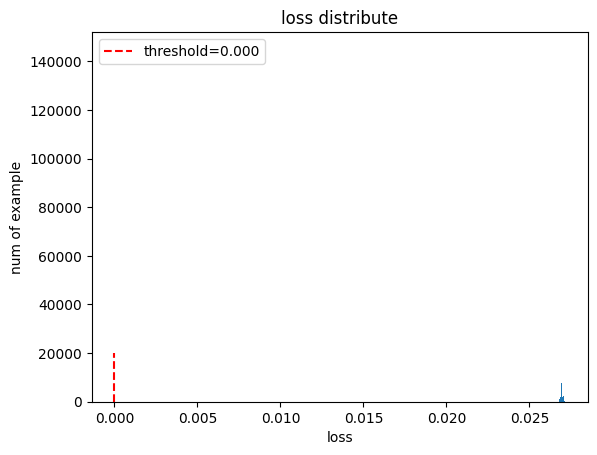

In [19]:
x=bs['Loss']
plt.title('loss distribute')
plt.xlabel('loss')
plt.ylabel('num of example')
plt.hist(x,bins=50)
plt.vlines(x=bestthreshold,ymin=0,ymax=20000,linestyles='dashed',colors='red',label='threshold='+'{0:1.3f}'.format(bestthreshold))
plt.legend()
plt.show()